In [140]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.integrate import quad

In [173]:
def distr(t,tau,V,dM):
    p = (1+V*np.sin(dM*t))*np.exp(-t/tau)
    return p
def getNorm(func,x,**kwargs):#uses quad integration method to normalise a function over a given range
    norm = quad(func,0,10,args=tuple(kwargs.values()))[0]
#     assert norm>0
    return norm 

Draw events from the PDF

In [142]:
class MC:

    def __init__(self, pdfFunc, **kwargs):
        self.pdf = pdfFunc
        self.pdfArgs = kwargs

    def populateEvents(self,myRange,noEvents):
        self.events = self.randFromFunc(self.pdf,noEvents,myRange,**self.pdfArgs)
        return self.events


#     def getDistFunc(self, G=None):
       
#         def fun(t):
#             return self.lam*np.exp(-self.lam*t)*(1-np.exp(-t/G))
#         return fun



#     def getBckFunc(self,mu,sig):
#         def fun(x):
#             return (1.0/np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
#         return fun
#     @staticmethod
#     def funcMax(func,range):
#         vfunc = np.vectorize(func)
#         inputs = np.linspace(range[0],range[1],10000)
#         #plt.plot(inputs,vfunc(inputs))
#         #plt.show()
#         #quit()
#         return(np.max(vfunc(inputs)))
    def randFromFunc(self,func, N,myrange,**kwargs):

        dist = np.zeros(N)
        for i in range(N):
            tryY = np.random.uniform(myrange[0][0],myrange[0][1])
            tryX = np.random.uniform(myrange[1][0],myrange[1][1])
            while tryY > func(tryX,**kwargs):
                tryY = np.random.uniform(myrange[0][0],myrange[0][1])
                tryX = np.random.uniform(myrange[1][0],myrange[1][1])
            dist[i] = tryX
        return dist
#     def addBckgrnd(self, frac):

#         myrange = [[0,1],[0,100*self.charTime]]
#         bckFun = self.getBckFunc(4*10**-6,1*10-15)
#         self.back = self.randFromFunc(bckFun,self.noEvents,myrange)
#         #plt.hist(self.back)
#         #plt.show()
#         self.events = frac*self.events + (1-frac)*self.back
#         return self.events

#     def eventsToFile(self,fName):#saves decay times to file
#         np.savetxt(fName,self.events)

#     def avgEvents(self):#calculates and returns the average decay time of each muon
#         avg = np.average(self.events)
#         return avg

#     def plotExper(self):#plots data as a histogram with line of best fit
#         plt.hist(self.events,bins='auto',normed=True)
#         p = expon.fit(self.events)
#         XX = np.linspace(0.00000001,0.00002,100)
#         PP = expon.pdf(XX,p[0],p[1])
#         plt.plot(XX,PP,'--r',linewidth=2)
#         plt.title("Muon Decay time")
#         plt.xlabel("Average decay time/seconds (s)")
#         plt.ylabel("Number of Muons")
#         plt.legend(["Line of best  fit"])
#         plt.show()


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


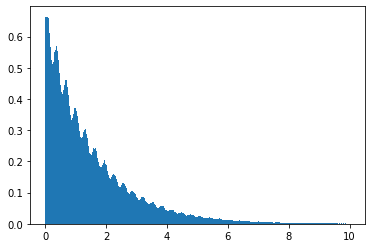

In [143]:
p = MC(distr,tau=1.5,V=0.1,dM=20)
data = p.populateEvents([[0,1],[0,10]],1000000)
plt.hist(data,bins='auto',normed=True)
plt.show()

In [144]:
def NLL(x,func,**kwargs):#negative log likelihood given an arbritory function and list of key work arguments
    normed = getNorm(func,x,**kwargs)
    P = func(x,**kwargs)/normed
    NLL = -np.log(P)

    NLL[P<=0] = 0.000001
    NLL[NLL == np.nan] = 1000000
    NLL[NLL == np.inf] = 1000000
    return NLL

In [178]:
def plotData(data,func,**kwargs):
    x=np.linspace(np.min(data),np.max(data),np.size(data))
    expected = func(x,**kwargs)
    normed = getNorm(func,x,**kwargs)
    expected /= normed
    plt.plot(x,expected)
    plt.hist(data,normed=True,bins='auto')
    plt.xlabel("Time")
    plt.ylabel("Normalised Bin Counts")
    plt.title(kwargs)
    

In [148]:
def nllFactory(data,func,plot=True):
    def nll(tau,V,dM):
        kwargs = {"tau":tau,"V":V,"dM":dM}
        totalNLL = np.sum(NLL(data,func, **kwargs))
        if plot:
            plotData(data,func,**kwargs)
            plt.show()
        return totalNLL
    return nll

In [149]:
nll = nllFactory(data,distr,plot=False)
nll(1.5,-0.1,20)

1403037.063639595

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:2: InitialParamWarning: Parameter dM is floating but does not have initial step size. Assume 1.
  
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:2: InitialParamWarning: errordef is not given. Default to 1.
  
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<ValueView of Minuit at 55b9cd9cbf08>
  tau: 1.5051416593498663
  V: 0.09610724367867997
  dM: 19.999219681777664


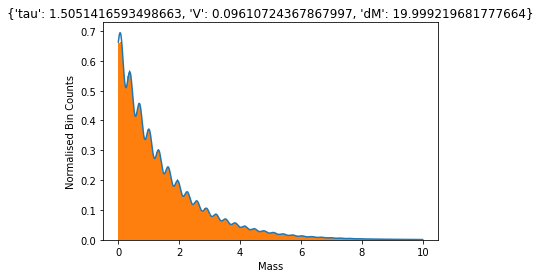

In [150]:
mins = Minuit(nll,tau=1, limit_tau=(0,4), error_tau=0.01,
            V=0.2, limit_V=(0.01,0.5), error_V=0.001, limit_dM=(0,np.inf),dM=21)
mins.migrad()
plotData(data,distr,**mins.values)
print(mins.values)
plt.show()

In [179]:
def fitData(data,func,args,plot=False):
    nll = nllFactory(data,func,plot=plot)
    mins = Minuit(nll,**args)
    mins.migrad()
    return mins

In [152]:
fitData(data,distr, mins.fitarg)

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
def runExpers(MCModel,noEvents,noRuns,minArgs):
    taus = []
    Vs = []
    dMs = []
    for i in range(noRuns):
        print("Run {}/{}".format(i,noRuns))
        data = p.populateEvents([[0,1],[0,10]],noEvents)
        mins = fitData(data,MCModel.pdf,minArgs)
        plotData(data,distr,**mins.values)
        print(mins.values)
        plt.show()
        taus.append(mins.values["tau"])
        Vs.append(mins.values["V"])
        dMs.append(mins.values["dM"])
    return {"tau":taus,"V":Vs,"dM":dMs}

Run 0/500
<ValueView of Minuit at 55b9cd33d9c8>
  tau: 1.5602230273090152
  V: 0.05550138445453364
  dM: 19.931836728696005


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


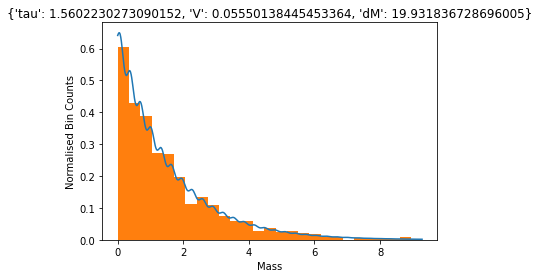

Run 1/500
<ValueView of Minuit at 55b9cda76248>
  tau: 1.500472785527752
  V: 0.16264689684018452
  dM: 20.046255480388524


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


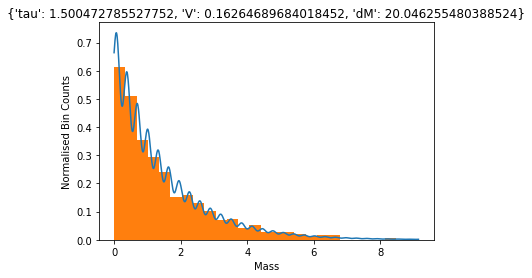

Run 2/500


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


<ValueView of Minuit at 55b9d1969f28>
  tau: 1.4563557522262056
  V: 0.16215391872034626
  dM: 19.774073311507234


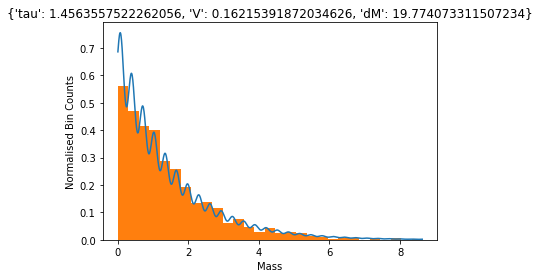

Run 3/500
<ValueView of Minuit at 55b9cdd4aed8>
  tau: 1.4525850799592983
  V: 0.18311908672515595
  dM: 19.941182726777942


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


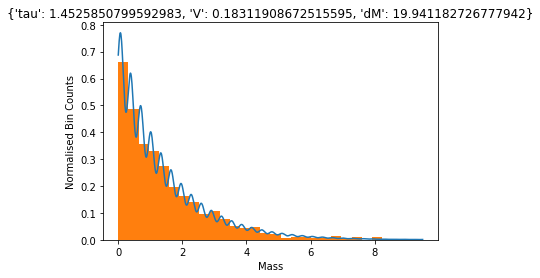

Run 4/500
<ValueView of Minuit at 55b9cd9cce88>
  tau: 1.5259959038989237
  V: 0.09403977144527031
  dM: 20.368335313465302


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


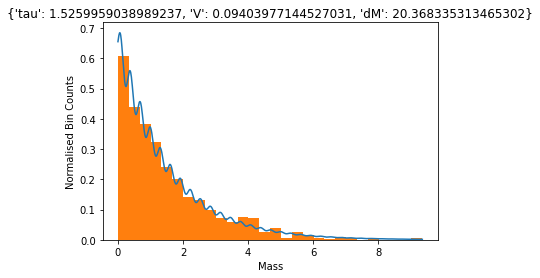

Run 5/500
<ValueView of Minuit at 55b9cd3b8918>
  tau: 1.5240757544770511
  V: 0.11667005219802783
  dM: 19.831554493640777


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


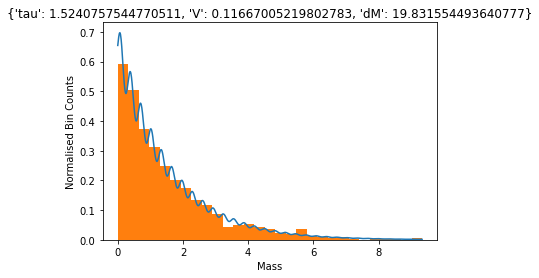

Run 6/500
<ValueView of Minuit at 55b9cdd1f258>
  tau: 1.569249034500183
  V: 0.09211890542708613
  dM: 20.182289870740128


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


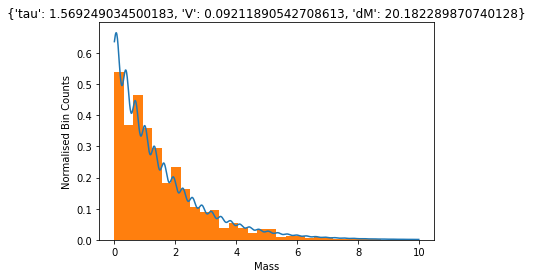

Run 7/500
<ValueView of Minuit at 55b9cd668bc8>
  tau: 1.4940025453696235
  V: 0.12186358602625176
  dM: 20.233930132530343


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


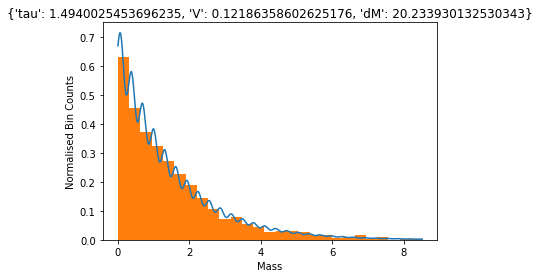

Run 8/500
<ValueView of Minuit at 55b9ce07c008>
  tau: 1.4787560704147236
  V: 0.12803715620855421
  dM: 20.15919725686997


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


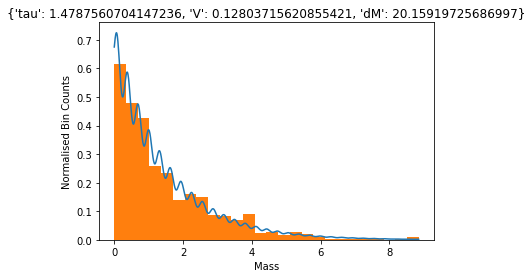

Run 9/500
<ValueView of Minuit at 55b9cd3d6f98>
  tau: 1.482104852945815
  V: 0.12263486877581205
  dM: 19.99879193938721


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

In [154]:
experData = runExpers(p,1000,500,mins.fitarg)

In [155]:
plt.hist(experData["tau"],normed=True,bins='auto')
plt.show()
plt.hist(experData["V"],normed=True,bins='auto')
plt.show()
plt.hist(experData["dM"],normed=True,bins='auto')
plt.show()

NameError: name 'experData' is not defined

In [156]:
experData["tau_sigma"]=np.std(experData['tau'])
experData["V_sigma"]=np.std(experData['V'])
experData["dM_sigma"]=np.std(experData['dM'])

NameError: name 'experData' is not defined

# Part 2

In [188]:
def biasData(data,f):
    res = 1.5*f
    dataBiased = np.random.normal(loc=data,scale=res)
    return dataBiased

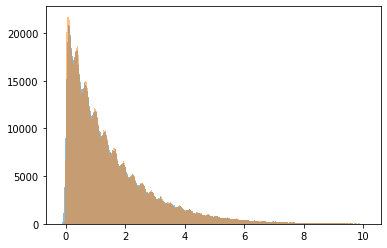

In [200]:
dataBiased1 = biasData(data,0.01)
dataBiased2 = biasData(data,0.03)
plt.hist(dataBiased2,bins='auto',alpha=0.5)
plt.hist(dataBiased1,bins='auto',alpha=0.5)
plt.show()

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<ValueView of Minuit at 55b9cd9cbf08>
  tau: 1.5051416593498663
  V: 0.09610724367867997
  dM: 19.999219681777664


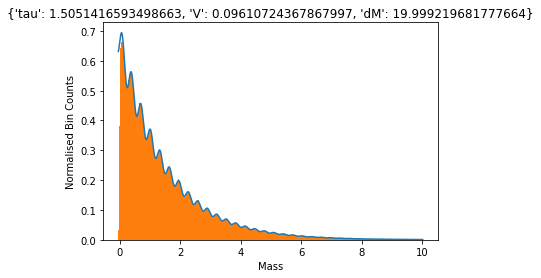

In [158]:
mins_biased = fitData(dataBiased,distr,mins.fitarg)
plotData(dataBiased,distr,**mins.values)
print(mins.values)
plt.show()

In [159]:
tau_bias = abs(mins.values["tau"]-mins_biased.values["tau"])
print(tau_bias)
V_bias = abs(mins.values["V"]-mins_biased.values["V"])
print(V_bias)
dM_bias = abs(mins.values["dM"]-mins_biased.values["dM"])
print(dM_bias)

0.00039065204037580514
0.007253215949905023
0.0019315683605896083


# Part 3

In [205]:
def distr_TA(t,tau,V,dM,s):
    p = distr(t,tau,V,dM)*(1+s*t)
    if isinstance(p,np.float64) or isinstance(p,float):
        if p<0:
            p=0
        assert p>=0
        return p
    elif isinstance(p,np.ndarray):
        p[np.where(p<0)] = 0
        assert np.all(p>=0)
        return p
    else:
        raise TypeError("Given type {}".format(type(p)))
    

In [206]:
def nllFactory_TA(data,func,plot=True,s=0):
    def nll(tau,V,dM):
        kwargs = {"tau":tau,"V":V,"dM":dM,"s":s}
        totalNLL = np.sum(NLL(data,func, **kwargs))
        if plot:
            plotData(data,func,**kwargs)
            plt.show()
        return totalNLL
    return nll

[-0.3        -0.26842105 -0.23684211 -0.20526316 -0.17368421 -0.14210526
 -0.11052632 -0.07894737 -0.04736842 -0.01578947  0.01578947  0.04736842
  0.07894737  0.11052632  0.14210526  0.17368421  0.20526316  0.23684211
  0.26842105  0.3       ]


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


[0.7696764788805524]


/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


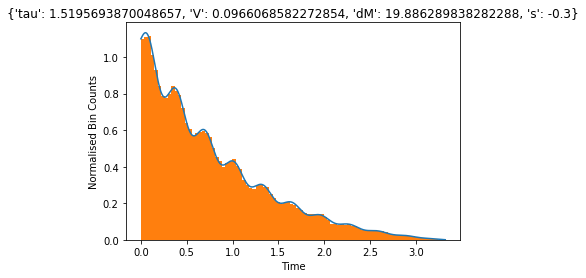

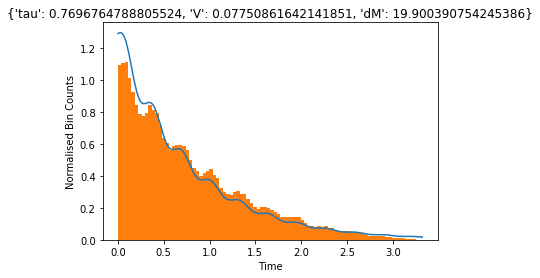

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWa

[0.7696764788805524, 0.8206202447787794]


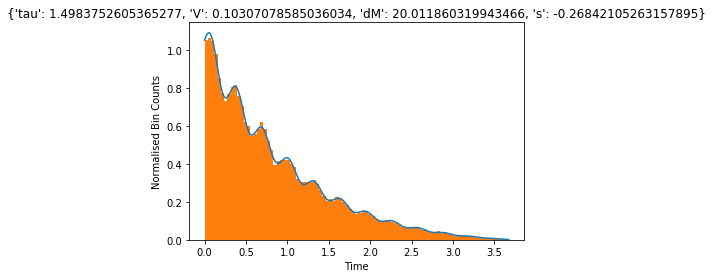

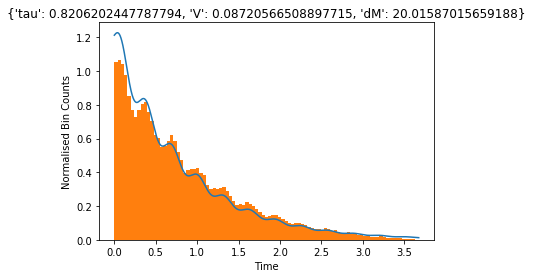

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672]


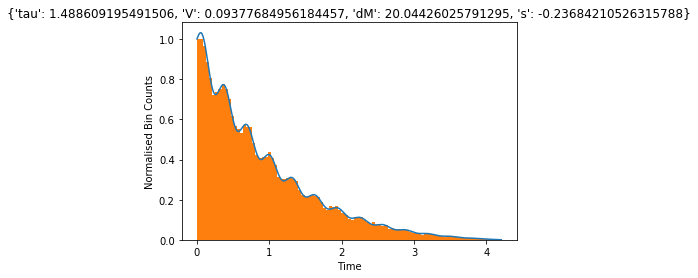

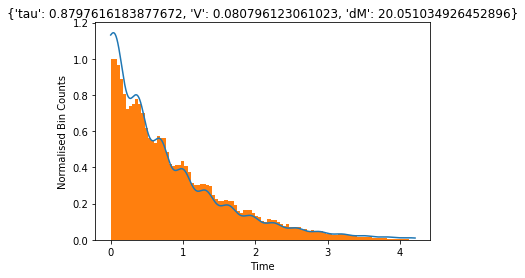

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392]


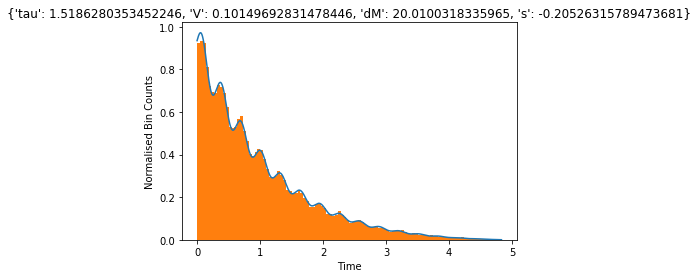

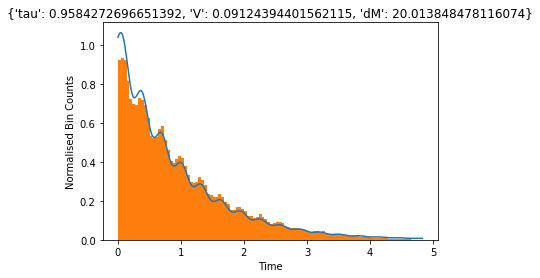

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506]


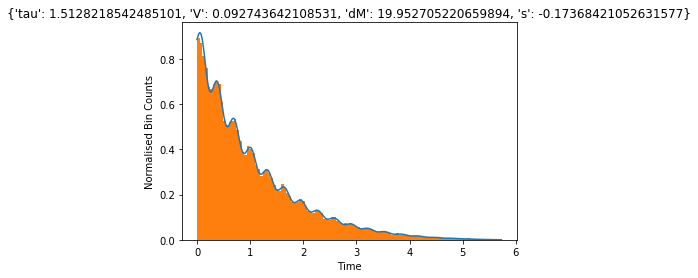

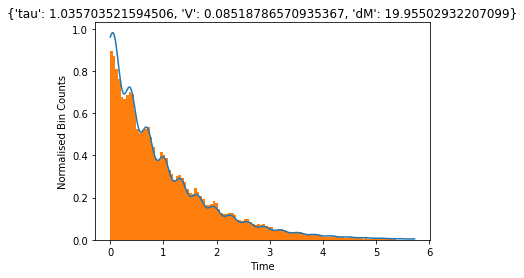

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496]


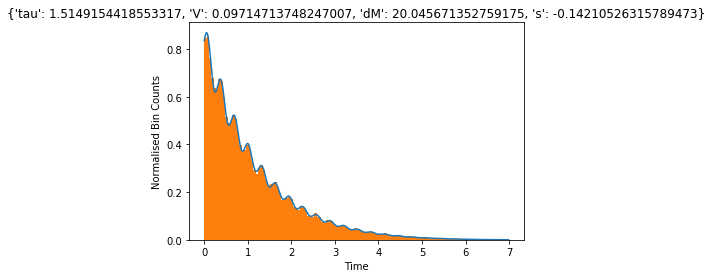

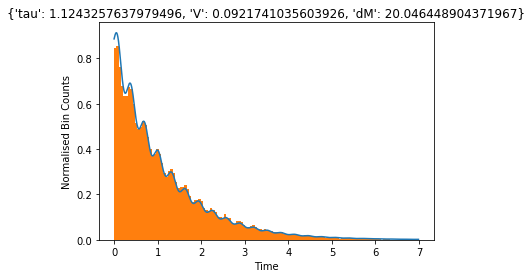

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203]


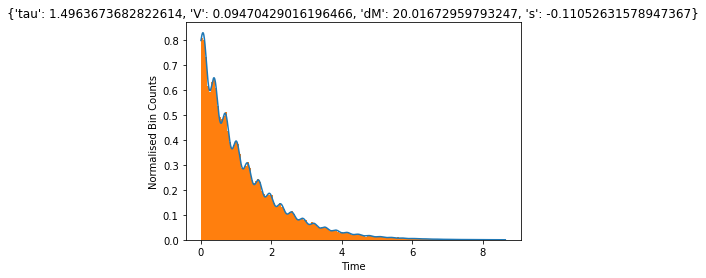

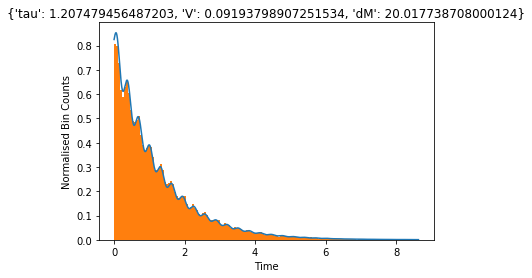

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742]


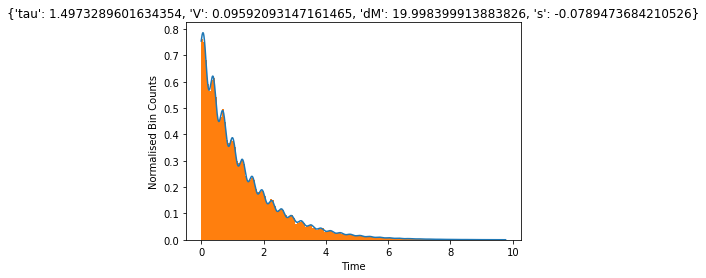

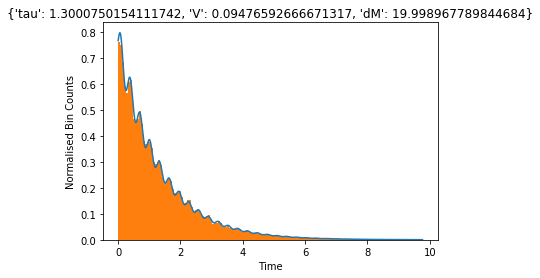

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461]


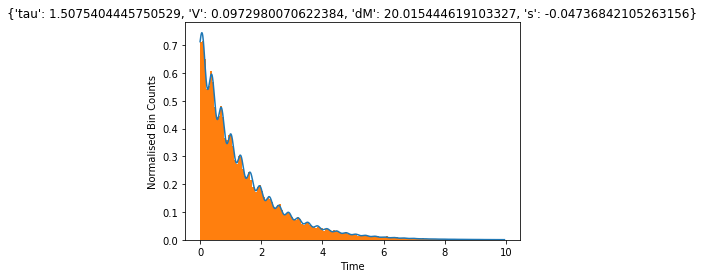

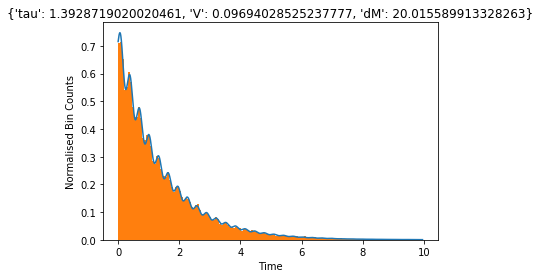

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857]


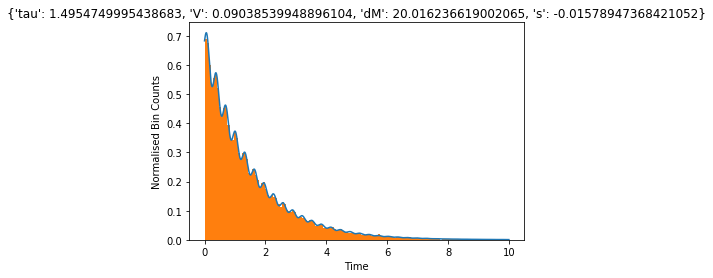

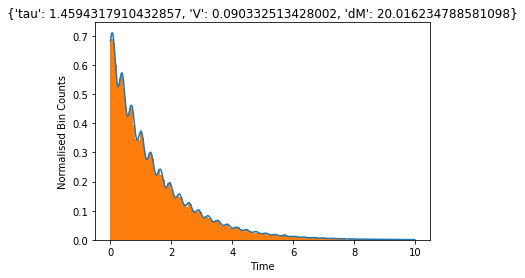

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495]


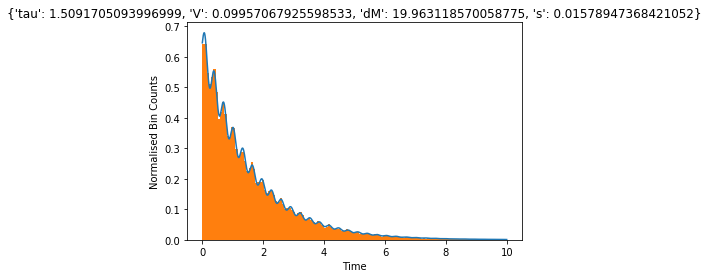

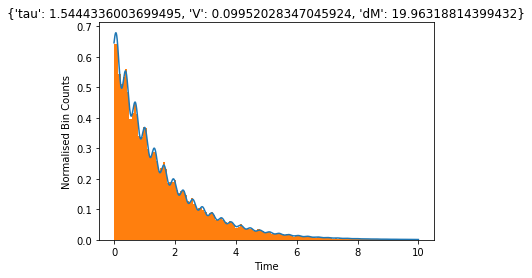

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052]


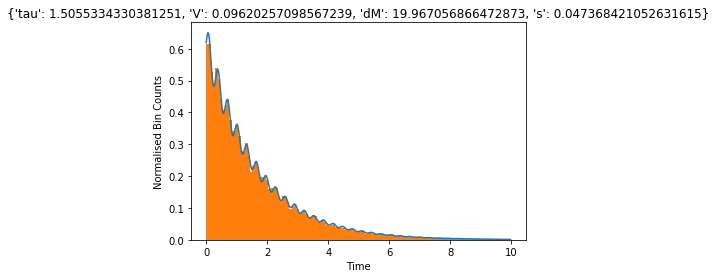

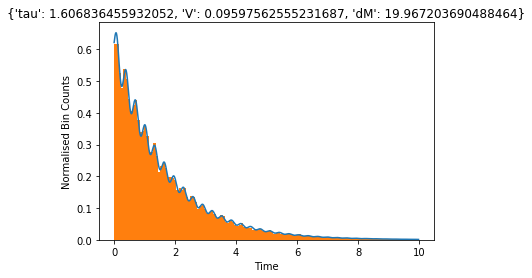

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497]


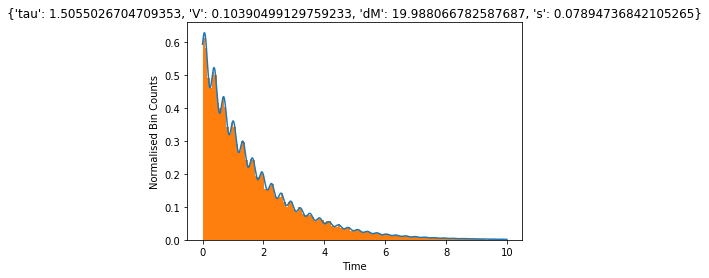

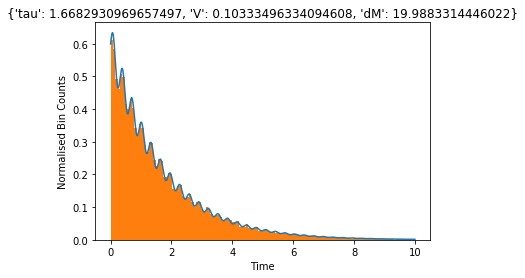

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587]


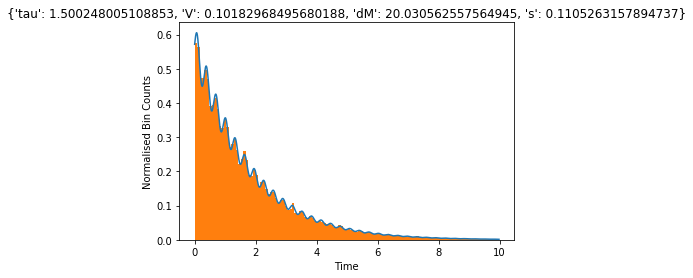

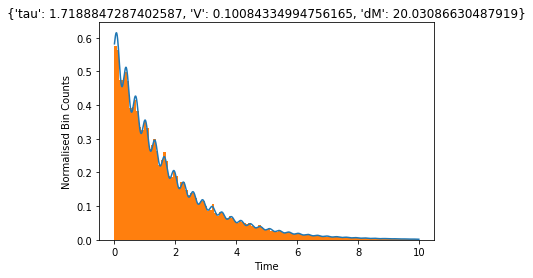

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587, 1.7795546913755496]


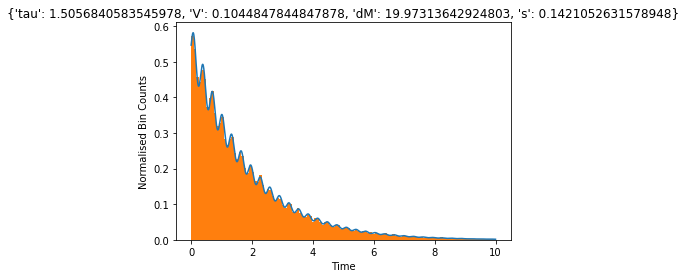

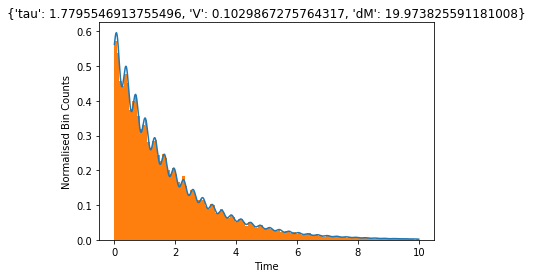

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587, 1.7795546913755496, 1.8348321294883838]


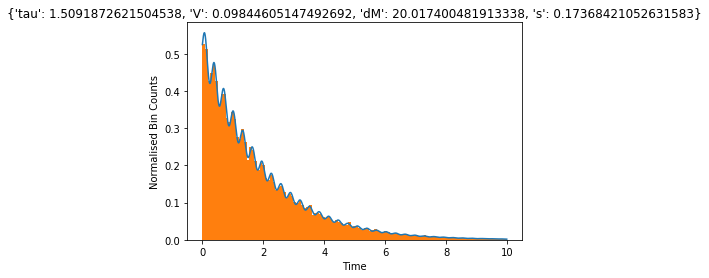

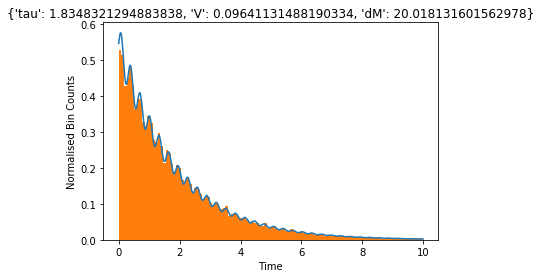

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587, 1.7795546913755496, 1.8348321294883838, 1.8714977009759066]


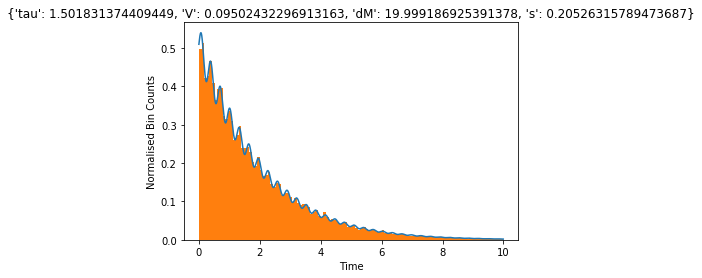

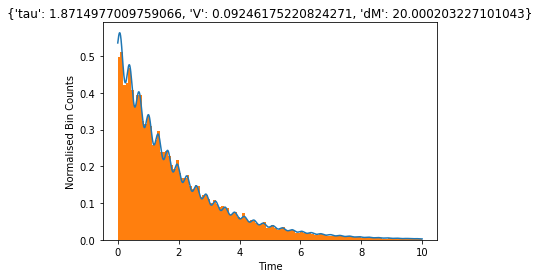

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587, 1.7795546913755496, 1.8348321294883838, 1.8714977009759066, 1.9110350035432093]


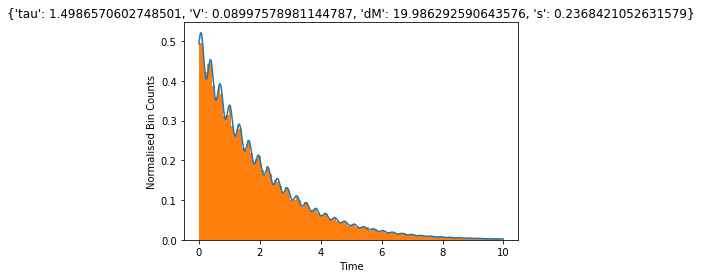

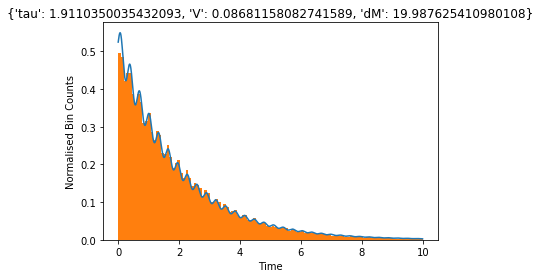

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587, 1.7795546913755496, 1.8348321294883838, 1.8714977009759066, 1.9110350035432093, 1.9637710719629669]


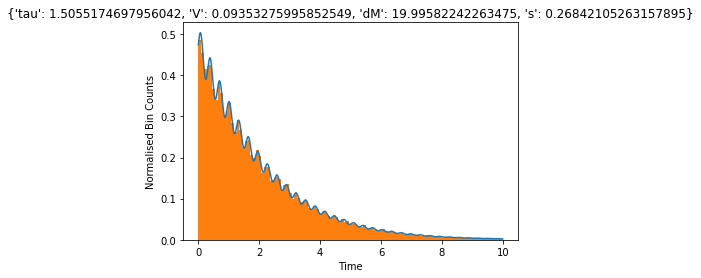

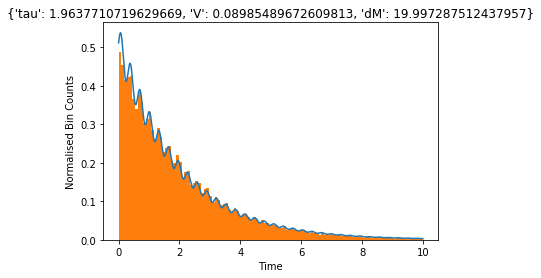

/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.
/Disk/opt/conda/pdaml/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: errordef is not given. Default to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.7696764788805524, 0.8206202447787794, 0.8797616183877672, 0.9584272696651392, 1.035703521594506, 1.1243257637979496, 1.207479456487203, 1.3000750154111742, 1.3928719020020461, 1.4594317910432857, 1.5444336003699495, 1.606836455932052, 1.6682930969657497, 1.7188847287402587, 1.7795546913755496, 1.8348321294883838, 1.8714977009759066, 1.9110350035432093, 1.9637710719629669, 2.0052330159603153]


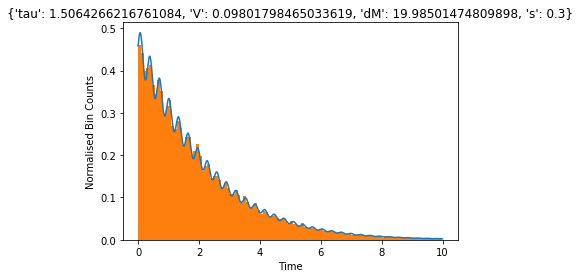

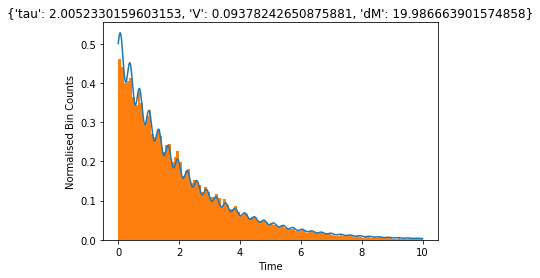

In [214]:
samples = 20
s_values = np.linspace(-0.3,0.3,samples)
print(s_values)
args_TA = mins.fitarg
taus = []
Vs = []
dMs = []
taus_TA = []
Vs_TA = []
dMs_TA = []
N = 100000
for i in range(samples):
    p_TA = MC(distr_TA,tau=1.5,V=0.1,dM=20,s=s_values[i])
    data_TA = MC(distr_TA,tau=1.5,V=0.1,dM=20,s=s_values[i]).populateEvents([[0,1],[0,10]],N)
    nll_TA = nllFactory_TA(data_TA,distr_TA,plot=False,s=s_values[i])
    nll_TA(1.5,0.1,20)
    mins_TA = Minuit(nll_TA,**args_TA)
    mins_normal = fitData(data_TA,distr,mins.fitarg,plot=False)
    mins_TA.migrad()
    taus_TA.append(mins_TA.values["tau"])
    Vs_TA.append(mins_TA.values["V"])
    dMs_TA.append(mins_TA.values["dM"])
    taus.append(mins_normal.values["tau"])
    Vs.append(mins_normal.values["V"])
    dMs.append(mins_normal.values["dM"])
    print(taus)
    plotData(data_TA,distr_TA,**mins_TA.values,**{"s":s_values[i]})
    plt.show()
    plotData(data_TA,distr,**mins_normal.values)
    plt.show()
    

In [216]:
tau_sys = np.max(np.abs(np.array(taus_TA)-np.array(taus)))
V_sys = np.max(np.abs(np.array(Vs_TA)-np.array(Vs)))
dM_sys = np.max(np.abs(np.array(dMs_TA)-np.array(dMs)))
print(tau_sys,V_sys,dM_sys)


0.7498929081243133 0.01909824180586689 0.01410091596309826
